# Geological facies classification using Random Forest

The goal of project is to create a model to predict geological facies, using well logs information. The geological facies are categories which helps to undertand the rock properties and this is a keys information to understand the behavior of the rocks in the subsurface, this information is required for the subsurface analysis in different areas like mining, oil and gas and carbon storage.

In the subsurface analysis the facies can be identified in perforation cores, however that informacion is very expensive and sparse. In other way, well logs are rutinary acquired in each log drilled and have a largest coverage including in some cases the entire well.

For tthis project, we are going to use a dataset contain well logs and facies information from different wells. This information was obtained for this repository (https://www.kaggle.com/datasets/imeintanis/well-log-facies-dataset?resource=download)

According to the description from the dataset, the nine discrete facies (classes of rocks) are:

1. SS: Nonmarine sandstone. 
2. CSiS: Nonmarine coarse siltstone
3. FSiS: Nonmarine fine siltstone
4. SiSH: Marine siltstone and shale
5. MS: Mudstone (limestone)
6. WS: Wackestone (limestone)
7. D: Dolomite
8. PS: Packstone-grainstone (limestone)
9. BS: Phylloid-algal bafflestone (limestone)



In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

The first step is to load the dataset called 'facies_data.csv'.
Next step is to perform an exploratory data analysis (EDA), for this step we are going to perform these tasks:
1. Print the first rows
2. Print general iformation about the dataframe
3. Print statistics from numerical variables
4. Verify if there are null values

In [112]:
#Step 1. Load the data
df = pd.read_csv("facies_data.csv")

#Step 2. Exploratory data analysis
# Print the first rows
print(df.head())

# Print general iformation about the dataframe
print(df.info())

# Print statistics from numerical variables
print(df.describe())

# Verify if there are null values
print(df.isnull().sum())

   Facies Formation  Well Name   Depth     GR  ILD_log10  DeltaPHI   PHIND  \
0       3     A1 SH  SHRIMPLIN  2793.0  77.45      0.664       9.9  11.915   
1       3     A1 SH  SHRIMPLIN  2793.5  78.26      0.661      14.2  12.565   
2       3     A1 SH  SHRIMPLIN  2794.0  79.05      0.658      14.8  13.050   
3       3     A1 SH  SHRIMPLIN  2794.5  86.10      0.655      13.9  13.115   
4       3     A1 SH  SHRIMPLIN  2795.0  74.58      0.647      13.5  13.300   

    PE  NM_M  RELPOS  
0  4.6     1   1.000  
1  4.1     1   0.979  
2  3.6     1   0.957  
3  3.5     1   0.936  
4  3.4     1   0.915  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3232 entries, 0 to 3231
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Facies     3232 non-null   int64  
 1   Formation  3232 non-null   object 
 2   Well Name  3232 non-null   object 
 3   Depth      3232 non-null   float64
 4   GR         3232 non-null   float64
 5   I

Once we have done a first review of the dataframe, we can observe the data we want to predict is the column called 'Facies', in addition we have some categorical variables ('Formation' and 'Well Name'), and another 8 columns with continuous variables.

We can analyse the continuous variables in detail in the next step, using histograms and boxplots:

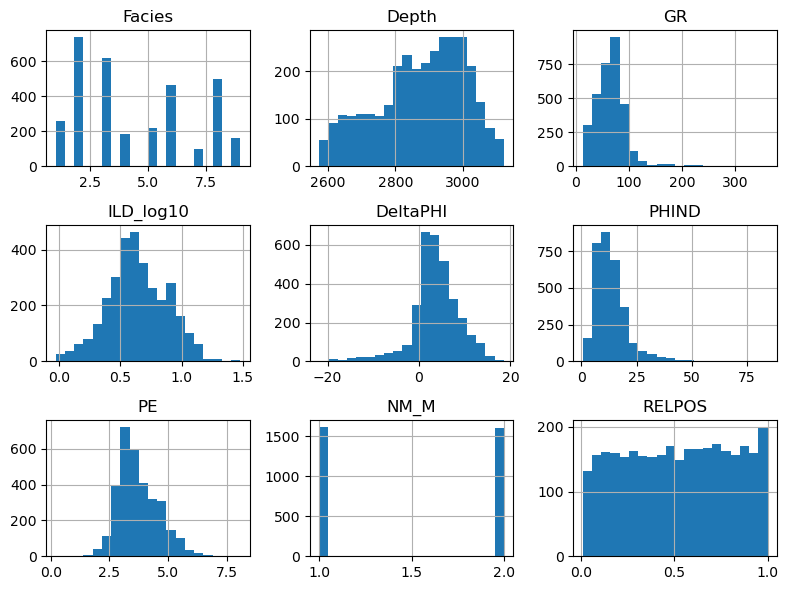

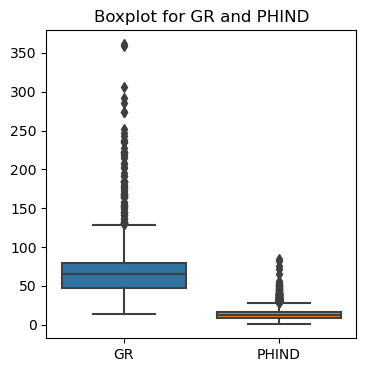

In [110]:
# Plot histograms for numeric variables
df.hist(bins=20, figsize=(8, 6))
plt.tight_layout()
plt.show()

# Boxplots to identify outliers
df_subset = df[['GR', 'PHIND']]
plt.figure(figsize=(4, 4))
sns.boxplot(data=df_subset)
plt.title("Boxplot for GR and PHIND")
plt.show()

We found the GR and PHIND have some otuliers; PHID mesaure the porosity of the rock and we should not expect values above 40, and for GR the typical range of values is from 0 to 150. So we are going to filter the data gased on these cutoffs.

In [113]:
df = df[df["PHIND"] <= 40]
df = df[df["GR"] <= 150]

Next we analyze the categorical variables, in this dataset we have three categorical variables ('Well Name', 'Formation' and 'Facies'):

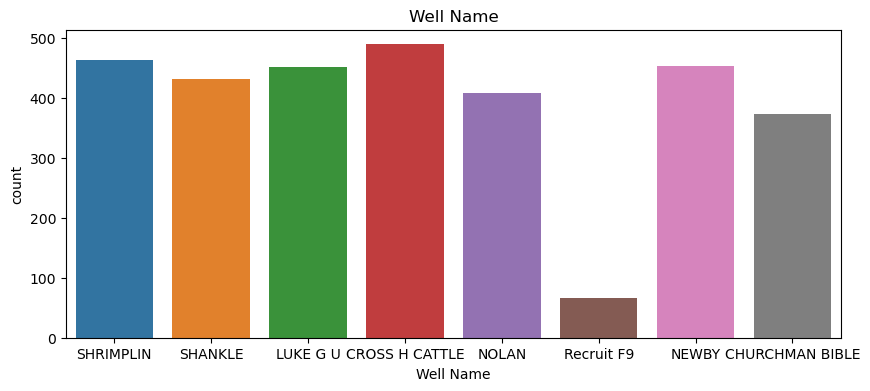

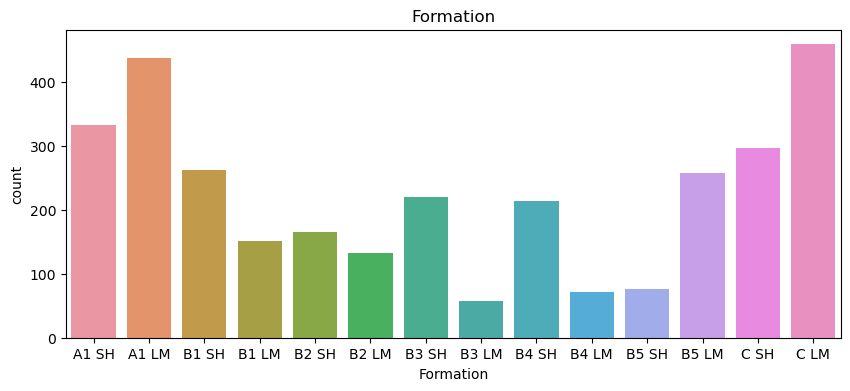

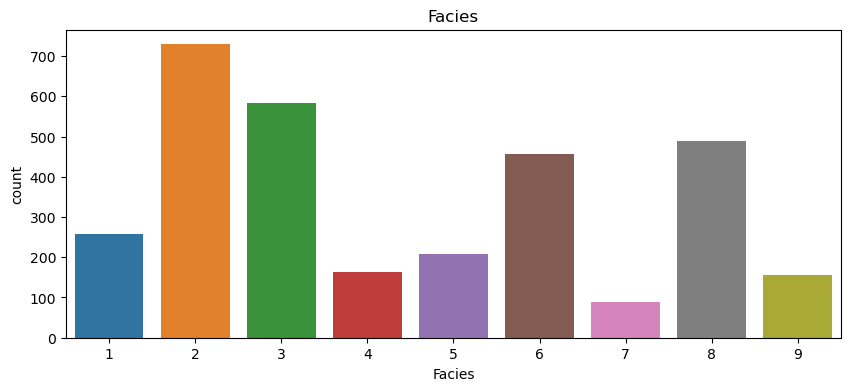

In [84]:
# Well Name distribution
#print(df['Well Name'].value_counts())
plt.figure(figsize=(10, 4))
sns.countplot(x='Well Name', data=df)
plt.title("Well Name")
plt.show()

# Formation distribution
#print(df['Formation'].value_counts())
plt.figure(figsize=(10, 4))
sns.countplot(x='Formation', data=df)
plt.title("Formation")
plt.show()

# Facies distribution
#print(df['Facies'].value_counts())
plt.figure(figsize=(10, 4))
sns.countplot(x='Facies', data=df)
plt.title("Facies")
plt.show()

In the next step, we are going to analyze the correlation between variables, we are going to plot the correlation matrix to identify if there is a high correlation between predictors. As yuou can notice, there are not values above 0.8, so we can conclude there is no correlation.

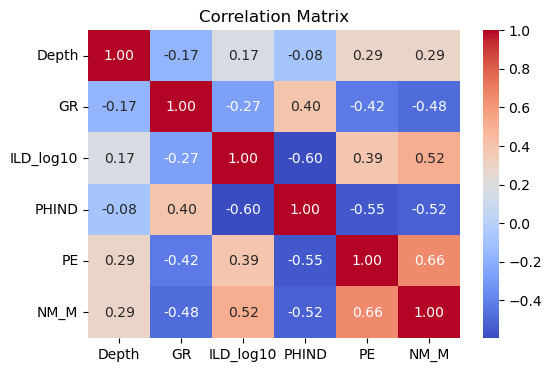

In [114]:
y = df[['Facies']].values
X = df[['Depth', 'GR', 'ILD_log10', 'PHIND', 'PE', 'NM_M']]
corr_matrix = X.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

After reviewing the data, we are going to discard the 'Formation' variable because it has too many categories and we are going to use the other variables to predict the facies.


#### Model 1

Next step we are going to split the data in training and test dataset, for this step we are going to use 80% of the data for training and 20% for testing.

We are going to use RandomForest to classify the Facies, using the 'Depth', 'GR', 'ILD_log10', 'PHIND', 'PE' and 'NM_M' variables as predictores, and then evaluate the model on the test dataset

In [115]:
y = df['Facies']
X = df[['Depth', 'GR', 'ILD_log10', 'PHIND', 'PE', 'NM_M']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [116]:
rf_classifier = RandomForestClassifier(n_estimators=100,min_samples_leaf=1, max_depth=None, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, y_pred),2))
print("\nClasification report:\n", classification_report(y_test, y_pred))

Accuracy: 0.77

Clasification report:
               precision    recall  f1-score   support

           1       0.88      0.77      0.82        48
           2       0.76      0.84      0.80       140
           3       0.79      0.78      0.79       120
           4       0.69      0.69      0.69        35
           5       0.76      0.46      0.58        41
           6       0.71      0.76      0.73       100
           7       0.78      0.78      0.78        18
           8       0.73      0.77      0.75        96
           9       0.96      0.90      0.93        29

    accuracy                           0.77       627
   macro avg       0.78      0.75      0.76       627
weighted avg       0.77      0.77      0.77       627



With this model, we obatined and accuracy of 0.77, this value is good considering the uncertainties we havae when we deal with geological information.

To have a better undertanding of the uncertainties of the model, we are going to use K-fold technique on the training set, to analyze the variantion in the accuracy.

The nine discrete facies (classes of rocks) are:

1 SS: Nonmarine sandstone. 
2 CSiS: Nonmarine coarse siltstone
FSiS: Nonmarine fine siltstone
SiSH: Marine siltstone and shale
MS: Mudstone (limestone)
WS: Wackestone (limestone)
D: Dolomite
PS: Packstone-grainstone (limestone)
BS: Phylloid-algal bafflestone (limestone)


In [117]:
from sklearn.model_selection import GroupKFold, cross_val_score
rf_classifier = RandomForestClassifier(n_estimators=100,min_samples_leaf=3, max_depth=None, random_state=42)
scores = cross_val_score(rf_classifier, X_train, y_train, cv=8, scoring='accuracy')
acc_scores = scores
print("K-fold evaluation:\n")
print("Accuracy for each fold:", acc_scores)
print("Accuracy mean:", round(acc_scores.mean(),2))


K-fold evaluation:

Accuracy for each fold: [0.71656051 0.7388535  0.71019108 0.72611465 0.70607029 0.71565495
 0.71246006 0.7028754 ]
Accuracy mean: 0.72


Using the K-fold evaluation we there is some variability in the results, but in average we are still close to the result of the first model.

In this scenario the model has a good result to predict the facies, which is great because normally facies labels are only available for an small segment of the well, and it is necesary to extrapolate the classification to the entire well.


#### Model 2
We can consider another scenario where we want to predict the facies for a new well. To evaluate this scenario we are going to split the training and test set considering the 'Well Name' category.

Next, we are going to create a new model using random forest again:

In [118]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=24)
train_idx, test_idx = next(gss.split(df, groups=df['Well Name']))
train_df = df.iloc[train_idx]
test_df = df.iloc[test_idx]

y_train = train_df['Facies']
X_train = train_df[['Depth', 'GR', 'ILD_log10', 'PHIND', 'PE', 'NM_M']]
y_test = test_df['Facies']
X_test = test_df[['Depth', 'GR', 'ILD_log10', 'PHIND', 'PE', 'NM_M']]

rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
print("\nEvaluation on the Test set:\n")
print("Accuracy:", round(accuracy_score(y_test, y_pred),2))
#print("\nClasification report:\n", classification_report(y_test, y_pred))


Evaluation on the Test set:

Accuracy: 0.59


The accuracy for this model is lower than the first scenario, one possibility is the wells are from different areas or maybe there are another geological considerations that are not included

In [93]:
### K-fold based on well
from sklearn.model_selection import GroupKFold, cross_val_score
groups = df["Well Name"]
group_kfold = GroupKFold(n_splits=8)
rf_classifier = RandomForestClassifier(n_estimators=100,min_samples_leaf=3, max_depth=None, random_state=42)
scores = cross_val_score(rf_classifier, X, y, cv=group_kfold, groups=groups, scoring='accuracy')
acc_scores = scores
print("K-fold evaluation:\n")
print("Accuracy for each fold:", acc_scores)
print("Accuracy mean:", round(acc_scores.mean(),2))


K-fold evaluation:

Accuracy for each fold: [0.31697342 0.58531317 0.43046358 0.40798226 0.50925926 0.47794118
 0.51206434 0.87878788]
Accuracy mean: 0.51


## Conclusions:

The goal of this project was to create a model to predict the geological facies, for that we use a random forest algorithm using the well logs as predictors. 

The results showed the model works good for facies classification, in special if want to interpret facies along the same well.

For the second scenario analyzed, where the objective was to make a prediction for a different well, the performance was slightly lower. This could be because the wells are from different areas, or because another geological factors not included in the analysis. This analysis could be improved included additional variables like the formation evaluation log,  or additional well logs (Sonic, Density and Neutron logs)